# 0. Import , Configure , Set Seed & Ingest

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sklearn as sk 
import re 
import html 
import os 
import bs4
import random
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [5]:
# REPRODUCIBILITY 
SEED = 42

def set_global_seed(seed):
    """
    Locks random number generators for reproducibility.
    """
    random.seed(seed)
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    np.random.seed(seed)
    
    print(f"Global Random Seed set to: {seed}")

set_global_seed(SEED)

Global Random Seed set to: 42


In [6]:
plt.style.use('ggplot')
sns.set_palette("viridis")

# 1. Exploratory Data Analysis

## 1.1. Basics

In [7]:
df = pd.read_csv("./dataset/development.csv")
df_test = pd.read_csv("./dataset/evaluation.csv")

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79997 entries, 0 to 79996
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         79997 non-null  int64 
 1   source     79997 non-null  object
 2   title      79996 non-null  object
 3   article    79996 non-null  object
 4   page_rank  79997 non-null  int64 
 5   timestamp  79997 non-null  object
 6   label      79997 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 4.3+ MB
None


In [9]:
display(df.head())

,Id,source,title,article,page_rank,timestamp,label
0,0,AllAfrica.com,OPEC Boosts Nigeria&#39;s Oil Revenue By .82m Bpd,THE Organisation of Petroleum Exporting Countr...,5,2004-09-16 22:39:53,5
1,1,Xinhua,Yearender: Mideast peace roadmap reaches dead-...,Looking back at the major events that took pla...,5,2004-12-17 19:01:14,0
2,2,Yahoo,Battleground Dispatches for Oct. 5 \\n (CQP...,CQPolitics.com - Here are today's Battleground...,5,2006-10-05 18:42:29,0
3,3,BBC,Air best to resuscitate newborns,Air rather than oxygen should be used to resus...,5,0000-00-00 00:00:00,0
4,4,Yahoo,High tech German train crash kills at least on...,"<p><a href=""http://us.rd.yahoo.com/dailynews/r...",5,2006-09-22 17:28:57,0


Problem Definition: This is a multi-class classification problem involving 7 categories (International News, Business, Technology, etc.)

Dataset Overview: approx. 100k instances and 5 features available (source, title, article, page_rank, timestamp).

## 1.2 Data Quality



We first check for how many missing values we have.

In [10]:
missing_summary= pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Percentage': df.isnull().sum() / len(df) * 100
}).sort_values('Percentage', ascending=False)

In [11]:
print("Missing Value Summary: ")
display(missing_summary)

Missing Value Summary: 


,Missing Count,Percentage
title,1,0.00125
article,1,0.00125
Id,0,0.00000
source,0,0.00000
page_rank,0,0.00000
timestamp,0,0.00000
label,0,0.00000


It's not that we have almost no missing values. They are in erroneous format. We are not able to reach them with the expected format ("NaN" or "NaT" values). We will go column by column to identify these missing values.

### a. Timestamp

In [12]:
print("Top 5 unique timestamp values:")
print(df['timestamp'].value_counts().head())

Top 5 unique timestamp values:
timestamp
0000-00-00 00:00:00    27750
2008-01-23 06:47:16        2
2007-03-05 19:48:41        2
2007-03-02 01:36:21        2
2007-07-17 18:42:49        2
Name: count, dtype: int64


The missing timestamp values are in this format: "0000-00-00 00:00:00"

In [13]:
temp_dates = pd.to_datetime(df['timestamp'], errors='coerce')
n_missing = temp_dates.isna().sum()
print(f"\nInvalid Dates (NaT after coercion): {n_missing}")
print(f"Percentage of missing dates: {(n_missing / len(df))}")


Invalid Dates (NaT after coercion): 27750
Percentage of missing dates: 0.34688800830031125


1/3 of our rows have missing dates.

### b. Pagerank

In [14]:
print(df['page_rank'].value_counts())

page_rank
5    73891
4     3692
3     2371
2       43
Name: count, dtype: int64


There is clear imbalance. 


Label Distribution by Page Rank (%)


label,0,1,2,3,4,5,6
page_rank,,,,,,,
2,0.0%,0.0%,100.0%,0.0%,0.0%,0.0%,0.0%
3,0.0%,0.0%,100.0%,0.0%,0.0%,0.0%,0.0%
4,0.0%,11.8%,58.7%,8.7%,20.8%,0.0%,0.0%
5,31.9%,13.7%,8.9%,13.1%,10.6%,17.7%,4.2%


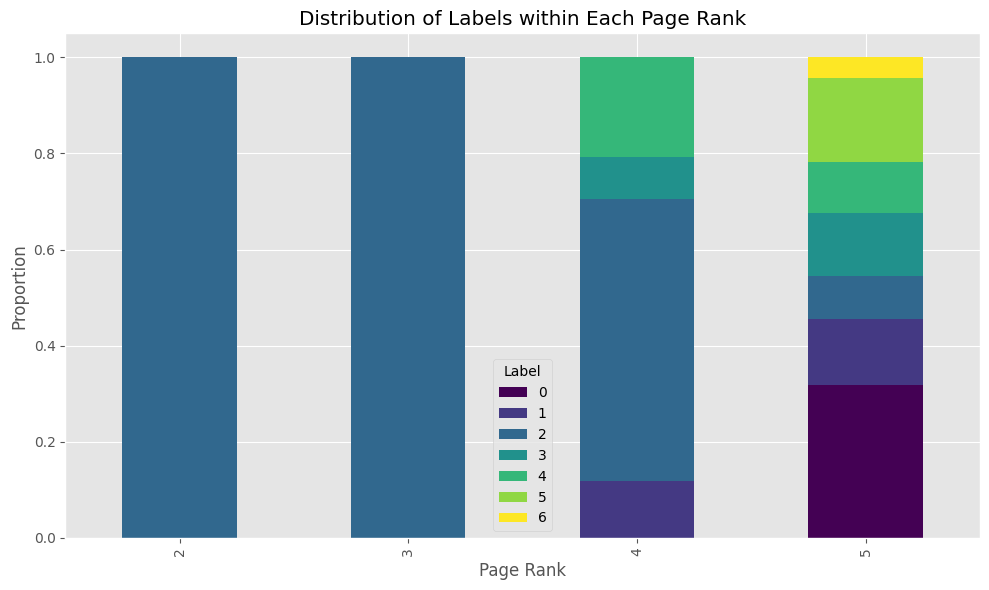

In [ ]:
# We want to see if a specific Page Rank makes a certain label more likely
page_rank_label = pd.crosstab(df['page_rank'], df['label'], normalize='index')

print("\nLabel Distribution by Page Rank (%)")
display(page_rank_label.style.format("{:.1%}"))

# We visualize as a Stacked Bar Chart
page_rank_label.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Distribution of Labels within Each Page Rank')
plt.xlabel('Page Rank')
plt.ylabel('Proportion')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

Page Rank 2 and 3 are 100% Label 2 ('Technology')

### c. Source

In [16]:
display(df[df['source'].str.len() < 2])

,Id,source,title,article,page_rank,timestamp,label
1260,1260,\,Ambush wipes &#163;4bn off value of online gam...,Business: Analysts compare crash with dotcom c...,5,2006-10-03 06:55:23,5
3009,3009,\,"Is it a man's, man's, man's world?",Laura Barton checks out the feminist credentia...,5,2007-03-14 07:50:32,5
4073,4073,\,Your cash can ease troubled young minds,A counselling service that can stop pupils dev...,5,2006-12-10 07:21:38,5
11532,11532,\,Just one tablet a day could keep heart attacks...,Life: Breakthrough to prevent arteries from cl...,5,0000-00-00 00:00:00,5
19217,19217,\,Cahoot suffers online security glitch,Money: A breakdown in the security system at o...,5,0000-00-00 00:00:00,5
19410,19410,\,Surgery and drugs to tackle child obesity epid...,Calls for drastic treatment for those as young...,5,2006-12-13 05:11:55,5
20820,20820,\,Yachtswomen take unassailable Olympic lead,Olympics: Trio of sailors win Britain's first ...,5,0000-00-00 00:00:00,5
21006,21006,\,Radcliffe ready for New York marathon,Sport: Huge TV audience ready for next episode...,5,0000-00-00 00:00:00,5
21742,21742,\,Colin MacCabe: Why exams are failing children,Education: In a frank open letter to Charles C...,5,0000-00-00 00:00:00,5
23348,23348,\,Director defends rating for explicit film,Film: Winterbottom defends 9 Songs and says he...,5,2004-10-24 06:10:40,5


In [17]:
display(df[df['source'].str.len() < 3])

,Id,source,title,article,page_rank,timestamp,label
445,445,ic,Tennis: Tim slams Cup rules after defeat,TIM Henman blasted the Davis Cup rule book as ...,5,0000-00-00 00:00:00,4
573,573,\N,Bristol-Myers Posts Lower Profit,Bristol-Myers Squibb's third-quarter profit wa...,5,0000-00-00 00:00:00,1
616,616,NW,Canadian MPs urge legal action over Barrow subs,CANADIAN prime minister Paul Martin and top na...,5,0000-00-00 00:00:00,3
670,670,\N,NHL Star Heatley Sentenced; No Jail,On <a href='http://www.newsisfree.com/sources/...,5,0000-00-00 00:00:00,5
948,948,\N,Kidnap hoax woman gets first mobile ASBO,No pay-as-you-go phone for five years,5,2004-11-10 16:39:29,2
...,...,...,...,...,...,...,...
79400,79400,\,Uefa Cup: Newcastle 2 - 1 Celta Vigo,Football: Steven Taylor grabs his first goal f...,5,2006-11-24 05:12:21,5
79472,79472,DM,E-Mail ID Working Group Shuts Down Without Con...,The Internet Engineering Task Force closed its...,5,0000-00-00 00:00:00,2
79487,79487,PC,IBM Recalls Notebook Power Cords,IBM is recalling power adapters that shipped w...,5,0000-00-00 00:00:00,2
79855,79855,\N,European stocks flat as financials weigh \\n ...,FT.com - Bid activity in the steel sector led ...,5,2007-01-31 12:45:27,0


We have identified two erroneous artifacts: "\\" & "\N"

In [18]:
missing_artifacts = ['\\', '\\N', 'nan', 'NULL' ]

In [19]:
mask_source = (df['source'].str.strip() == '') | (df['source'].isin(missing_artifacts)) | df['source'].isna()
missing_source_rows = df[mask_source]
print(f"Total rows with missing source:{len(missing_source_rows)}")
display(missing_source_rows)

Total rows with missing source:328


,Id,source,title,article,page_rank,timestamp,label
573,573,\N,Bristol-Myers Posts Lower Profit,Bristol-Myers Squibb's third-quarter profit wa...,5,0000-00-00 00:00:00,1
670,670,\N,NHL Star Heatley Sentenced; No Jail,On <a href='http://www.newsisfree.com/sources/...,5,0000-00-00 00:00:00,5
948,948,\N,Kidnap hoax woman gets first mobile ASBO,No pay-as-you-go phone for five years,5,2004-11-10 16:39:29,2
1260,1260,\,Ambush wipes &#163;4bn off value of online gam...,Business: Analysts compare crash with dotcom c...,5,2006-10-03 06:55:23,5
1605,1605,\N,EU Socialists Vote for Constitution Despite Fr...,Reuters - Socialist members of the European\\n...,5,0000-00-00 00:00:00,0
...,...,...,...,...,...,...,...
78652,78652,\N,Joy (Global) to the World!,Leading manufacturer of mining equipment annou...,5,2007-12-20 21:41:27,1
78859,78859,\N,Mario Vazquez & American Idol Sued,"Magdaleno Olmos, assistant accountant for Frem...",5,2007-03-13 15:51:29,3
79373,79373,\N,Baghdad college bomber was female,A suicide bomber who killed 42 people in an at...,5,2007-02-26 11:08:52,5
79400,79400,\,Uefa Cup: Newcastle 2 - 1 Celta Vigo,Football: Steven Taylor grabs his first goal f...,5,2006-11-24 05:12:21,5


### d. Title & Article

We basically want to run the same analysis for title & article, since they are all text-based.

In [20]:
display(df[df['title'].str.len() < 4])

,Id,source,title,article,page_rank,timestamp,label
278,278,Washington,,"<br clear=""all""><a href=""http://ad.doublecli...",5,2006-11-21 17:04:52,0
19049,19049,Topix.Net,Uk,Trace your roots to the British Isles with 500...,5,0000-00-00 00:00:00,0
41473,41473,Washington,,House Committee on Energy and Commerce Subcom...,5,2006-09-28 23:33:10,2


In [21]:
display(df[df['article'].str.len() < 2])

,Id,source,title,article,page_rank,timestamp,label
654,654,CNET,Photo gallery: Robots in action,,3,0000-00-00 00:00:00,2
36842,36842,CNET,Apple may go galactic,,3,0000-00-00 00:00:00,2
47900,47900,CNET,Photo gallery: iPod gets the picture,,3,0000-00-00 00:00:00,2
66175,66175,CNET,Hitachi unleashes 100GB notebook drives,,3,0000-00-00 00:00:00,2


In [22]:
display(df[df['article'].str.len() < 3])

,Id,source,title,article,page_rank,timestamp,label
86,86,International,The Workplace: It&#x27;s called mobbing,\N,5,2007-02-05 19:22:08,1
91,91,CNN,Iraqi interim president: Insurgents gone in a ...,\N,5,2004-12-09 08:22:49,5
127,127,CNN,Tsunami doctors badly hit in Indonesia,\N,5,0000-00-00 00:00:00,5
151,151,International,Spotlight: Recruiting the recruiter,\N,5,2006-09-22 23:48:41,1
152,152,International,Gabonese hope for windfall as Chinese develop ...,\N,5,2007-02-26 14:49:23,1
...,...,...,...,...,...,...,...
79739,79739,CNN,U.S.: 109 insurgents killed,\N,5,2004-10-02 20:18:46,5
79792,79792,Forbes,Complete Coverage: Leadership,\N,5,2007-10-30 14:33:24,1
79839,79839,CNN,Hong Kong Democrats demand recount,\N,5,2004-09-13 19:04:44,5
79947,79947,Washington,Campaign for Change Resonates at the Polls,\N,5,2006-09-14 11:27:27,5


Seems like articles are also filled with "\N" and white-space related issues. We create the masks to identify rows where ANY of these columns are bad.

In [23]:
mask_title = (df['title'].str.strip() == '') | (df['title'].isin(missing_artifacts)) | (df['title'].isna())
mask_article = (df['article'].str.strip() == '') | (df['article'].isin(missing_artifacts)) | df['article'].isna()

In [24]:
missing_mask = mask_source | mask_title | mask_article
missing_rows = df[missing_mask]

In [25]:
display(missing_rows)

,Id,source,title,article,page_rank,timestamp,label
86,86,International,The Workplace: It&#x27;s called mobbing,\N,5,2007-02-05 19:22:08,1
91,91,CNN,Iraqi interim president: Insurgents gone in a ...,\N,5,2004-12-09 08:22:49,5
127,127,CNN,Tsunami doctors badly hit in Indonesia,\N,5,0000-00-00 00:00:00,5
151,151,International,Spotlight: Recruiting the recruiter,\N,5,2006-09-22 23:48:41,1
152,152,International,Gabonese hope for windfall as Chinese develop ...,\N,5,2007-02-26 14:49:23,1
...,...,...,...,...,...,...,...
79792,79792,Forbes,Complete Coverage: Leadership,\N,5,2007-10-30 14:33:24,1
79839,79839,CNN,Hong Kong Democrats demand recount,\N,5,2004-09-13 19:04:44,5
79855,79855,\N,European stocks flat as financials weigh \\n ...,FT.com - Bid activity in the steel sector led ...,5,2007-01-31 12:45:27,0
79947,79947,Washington,Campaign for Change Resonates at the Polls,\N,5,2006-09-14 11:27:27,5


We will use masks to normalize missing values. We don't intend to remove any row, unless there is absolutely no data to help us. For example, let's say we removed a row because it had no title or article. That row's source, page_rank & timestamp could still hold valuable information. We will check which are the rows that contain the least amount of information, but remain cautious when choosing to remove them.

In [26]:
def clean_and_analyze_dataset(df):
    """
    Performs mechanical cleaning and returns both the cleaned dataframe
    and a summary of the data quality issues found using masks.
    """
    df_clean = df.copy()

    # Define Artifacts
    missing_artifacts = ['\\N', '\\', 'nan', 'NULL']

    # Create Masks
    mask_source = (df_clean['source'].str.strip() == '') | (df_clean['source'].isin(missing_artifacts)) | df_clean['source'].isna()
    mask_title = (df_clean['title'].str.strip() == '') | (df_clean['title'].isin(missing_artifacts)) | df_clean['title'].isna()
    mask_article = (df_clean['article'].str.strip() == '') | (df_clean['article'].isin(missing_artifacts)) | df_clean['article'].isna()

    mask_text = mask_source | mask_title | mask_article

    # Apply Cleaning (Standardize to np.nan)
    df_clean.loc[mask_source, 'source'] = np.nan
    df_clean.loc[mask_title, 'title'] = np.nan
    df_clean.loc[mask_article, 'article'] = np.nan

    # Handle Timestamps
    # Coerce errors to NaT
    df_clean['timestamp_clean'] = pd.to_datetime(df_clean['timestamp'], errors='coerce')
    mask_date_issue = df_clean['timestamp_clean'].isna()
    # Replace original column
    df_clean['timestamp'] = df_clean['timestamp_clean']
    df_clean.drop(columns=['timestamp_clean'], inplace=True)

    # Handle Page Rank
    # Coerce non-numeric to NaN
    df_clean['page_rank'] = pd.to_numeric(df_clean['page_rank'], errors='coerce')

    # Generate Report Stats
    stats = {
        'total_rows': len(df),
        'missing_source': mask_source.sum(),
        'missing_title': mask_title.sum(),
        'missing_article': mask_article.sum(),
        'rows_with_any_text_missing': mask_text.sum(),
        'missing_dates': mask_date_issue.sum(),
        'pct_missing_dates': (mask_date_issue.sum() / len(df)) * 100
    }

    return df_clean, stats

In [27]:
# Apply the cleaning
df_clean, quality_stats = clean_and_analyze_dataset(df)

print("--- Data Quality Report ---")
print(f"Total Rows: {quality_stats['total_rows']}")
print(f"Rows with Missing Source: {quality_stats['missing_source']}")
print(f"Rows with Missing Title: {quality_stats['missing_title']}")
print(f"Rows with Missing Article: {quality_stats['missing_article']}")
print(f"Rows with ANY Text Missing: {quality_stats['rows_with_any_text_missing']}")
print("-" * 30)
print(f"Rows with Invalid/Missing Dates: {quality_stats['missing_dates']}")
print(f"Percentage of Missing Dates: {quality_stats['pct_missing_dates']:.2f}%")

--- Data Quality Report ---
Total Rows: 79997
Rows with Missing Source: 328
Rows with Missing Title: 3
Rows with Missing Article: 1882
Rows with ANY Text Missing: 2204
------------------------------
Rows with Invalid/Missing Dates: 27750
Percentage of Missing Dates: 34.69%


Since we have purely NaN and NaT values now, we rely on the fact that Pandas duplicated() considers NaN equal to NaN, which helps us find duplicates even in incomplete rows.

In [28]:
# We ignore 'id' because that's just a database index.
subset_cols = ['title', 'article', 'source']
dup_content = df_clean[df_clean.duplicated(subset=subset_cols, keep=False)]

print(f"Rows with duplicate Content: {len(dup_content)}")

# Let's peek at an example of content duplicates if they exist
if not dup_content.empty:
    print("\nExample of Content Duplicates:")
    # Sort by title so duplicates appear next to each other
    display(dup_content.sort_values(by='title').head(4))

Rows with duplicate Content: 5372

Example of Content Duplicates:


,Id,source,title,article,page_rank,timestamp,label
29901,29901,Washington,Bush Wants $50 Billion More for Iraq War,President Bush plans to ask Congress next mon...,5,2007-08-29 08:07:03,0
9257,9257,Washington,Bush Wants $50 Billion More for Iraq War,President Bush plans to ask Congress next mon...,5,2007-08-29 07:10:42,0
28304,28304,Washington,China Imposes New Restrictions on Organ Trans...,"BEIJING, July 3 -- The Chinese government imp...",5,2007-07-03 15:32:28,0
31251,31251,Washington,China Imposes New Restrictions on Organ Trans...,"BEIJING, July 3 -- The Chinese government imp...",5,2007-07-03 14:44:58,0


There are rows with fully duplicate content (source, title, article, page_rank, timestamp) but different labels. 

We have to detect these conflicts by finding groups with the same content (title, article, source) but different labels.

If a conflicted row is labeled "General News" (5) and its duplicate is "Sports" (4), the specific label is almost always the correct one. We keep the "Sports" row.

If a row is "Sports" and its duplicate is "Business", we can't know the truth. We drop both to prevent confusing the model.

Deduplicate the Rest: For the remaining redundant rows (same label), we will keep the one with the earliest timestamp.

In [29]:
def deduplicate(df):
    df_clean = df.copy()
    
    content_definition_columns = ['title', 'article', 'source']
    df_clean['is_generic_label'] = (df_clean['label'] == 5)
    
    # Sort by:
    #   1. Title (group duplicates together)
    #   2. Is General? (Specific labels float to top)
    #   3. Timestamp (Earliest date floats to top)
    df_clean = df_clean.sort_values(
        by=['title', 'is_generic_label', 'timestamp'], 
        ascending=[True, True, True]
    )
    
    # Filter to only rows that have specific (non-general) labels
    has_specific_label_mask = df_clean['label'] != 5
    rows_with_specific_labels = df_clean[has_specific_label_mask]
    
    # Count unique labels per content group
    label_counts_per_content = rows_with_specific_labels.groupby(content_definition_columns)['label'].nunique()
    
    # Identify content that has >1 specific label (Contradiction)
    content_with_contradictions = label_counts_per_content[label_counts_per_content > 1].index
    
    # Remove Irreconcilable Rows
    if len(content_with_contradictions) > 0:
        print(f"Dropping {len(content_with_contradictions)} articles with impossible label conflicts.")
        # Set index to allow easy dropping by content tuple
        df_clean = df_clean.set_index(content_definition_columns)
        df_clean = df_clean.drop(index=content_with_contradictions).reset_index()
    
    # Deduplicate Remaining Rows
    initial_row_count = len(df_clean)
    df_final = df_clean.drop_duplicates(subset=content_definition_columns, keep='first')
    
    df_final = df_final.drop(columns=['is_generic_label'])
    
    rows_removed = initial_row_count - len(df_final)
    print(f"Smart Deduplication Complete. Removed {rows_removed} redundant rows.")
    print(f"Final Dataset Size: {len(df_final)} rows.")
    
    return df_final

In [30]:
df_clean = deduplicate(df_clean)

Dropping 519 articles with impossible label conflicts.
Smart Deduplication Complete. Removed 2275 redundant rows.
Final Dataset Size: 76613 rows.


In [58]:
def plot_cleaning_impact(df_raw, df_clean):
    raw_counts = df_raw['label'].value_counts().sort_index()
    clean_counts = df_clean['label'].value_counts().sort_index()
    
    label_map = {
        0: 'International (0)', 1: 'Business (1)', 2: 'Technology (2)',
        3: 'Entertainment (3)', 4: 'Sports (4)', 5: 'General (5)', 6: 'Health (6)'
    }
    
    comparison = pd.DataFrame({
        'Label': [label_map[i] for i in raw_counts.index],
        'Raw': raw_counts.values,
        'Cleaned': clean_counts.values
    })
    
    comparison_melt = comparison.melt(id_vars='Label', var_name='Dataset', value_name='Count')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=comparison_melt, x='Label', y='Count', hue='Dataset', palette=['#d3d3d3', '#1f77b4'])
    
    plt.title('Impact of Cleaning on Label Distribution', fontsize=14)
    plt.ylabel('Number of Articles')
    plt.xlabel('Label')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    for i, label in enumerate(comparison['Label']):
        raw_val = comparison.loc[i, 'Raw']
        clean_val = comparison.loc[i, 'Cleaned']
        drop_pct = ((raw_val - clean_val) / raw_val) * 100
        
        plt.text(i + 0.2, clean_val + 500, f'-{drop_pct:.1f}%', 
                 ha='center', va='bottom', fontsize=9, color='red')
    
    plt.tight_layout()
    plt.show()
    
    return comparison

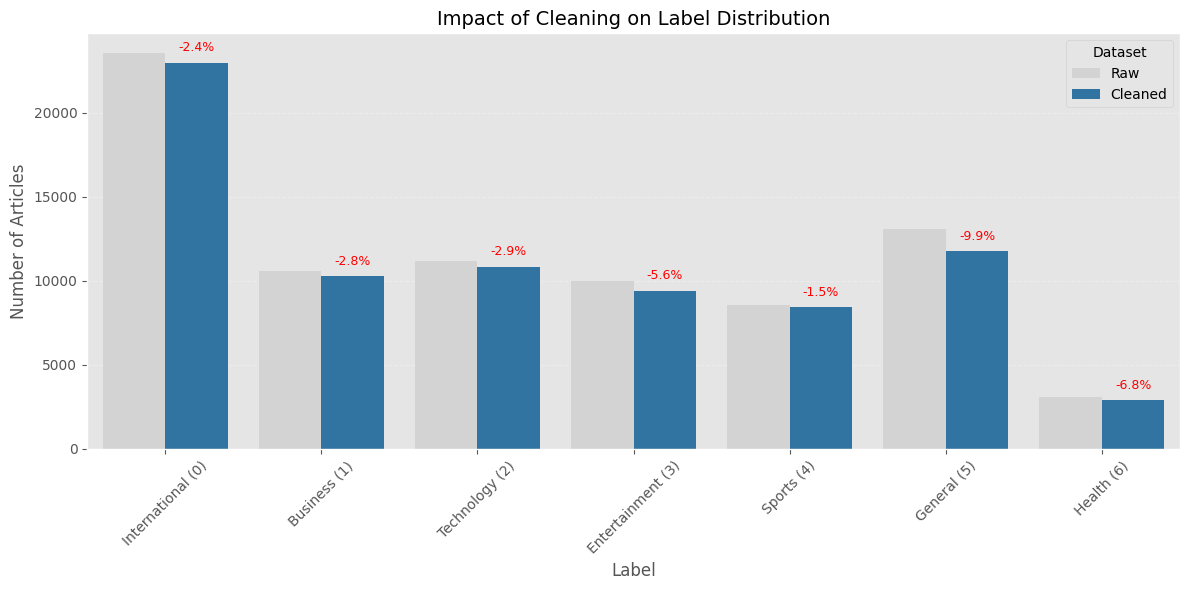

,Label,Raw,Cleaned
0,International (0),23542,22973
1,Business (1),10588,10292
2,Technology (2),11161,10834
3,Entertainment (3),9977,9416
4,Sports (4),8574,8445
5,General (5),13053,11761
6,Health (6),3102,2892


In [59]:
impact_stats = plot_cleaning_impact(df, df_clean)
display(impact_stats)

## 1.3 Univariate Analysis

### a. Summary

In [33]:
missing_summary= pd.DataFrame({
    'Missing Count': df_clean.isnull().sum(),
    'Percentage': df_clean.isnull().sum() / len(df) * 100
}).sort_values('Percentage', ascending=False)

In [34]:
print("Missing Value Summary: ")
display(missing_summary)

Missing Value Summary: 


,Missing Count,Percentage
timestamp,26341,32.927485
article,1865,2.331337
source,328,0.410015
title,3,0.003750
Id,0,0.000000
page_rank,0,0.000000
label,0,0.000000


### b. Source Distribution

/var/folders/kk/clxttl7j5wvbs_fcnydk843r0000gn/T/ipykernel_79832/504283468.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='Source', y='Count', palette='viridis')


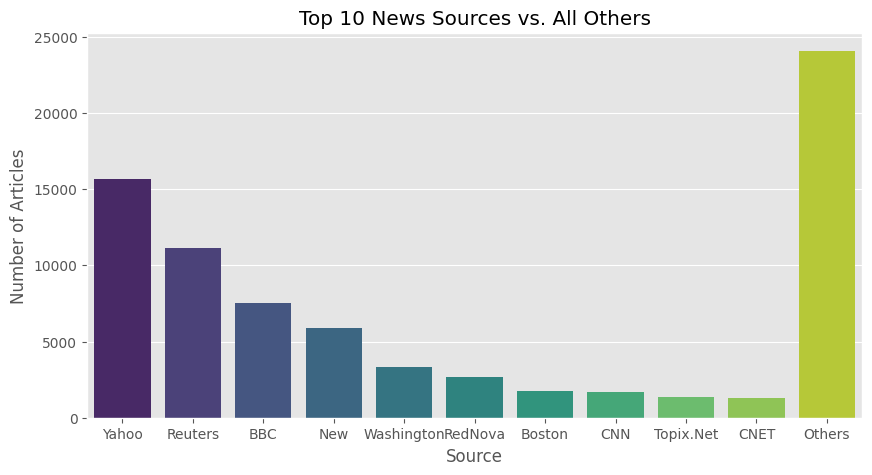

In [35]:
# Configuration
top_n_sources = 10

# Calculate counts
source_counts = df_clean['source'].value_counts()
top_sources = source_counts.head(top_n_sources)
other_count = source_counts.iloc[top_n_sources:].sum()

# Create dataframe for plotting
plot_data = pd.DataFrame({
    'Source': top_sources.index.tolist() + ['Others'],
    'Count': top_sources.values.tolist() + [other_count]
})

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=plot_data, x='Source', y='Count', palette='viridis')
plt.title(f'Top {top_n_sources} News Sources vs. All Others')
plt.ylabel('Number of Articles')
plt.show()

### c. Timestamp Analysis (Train vs. Test)

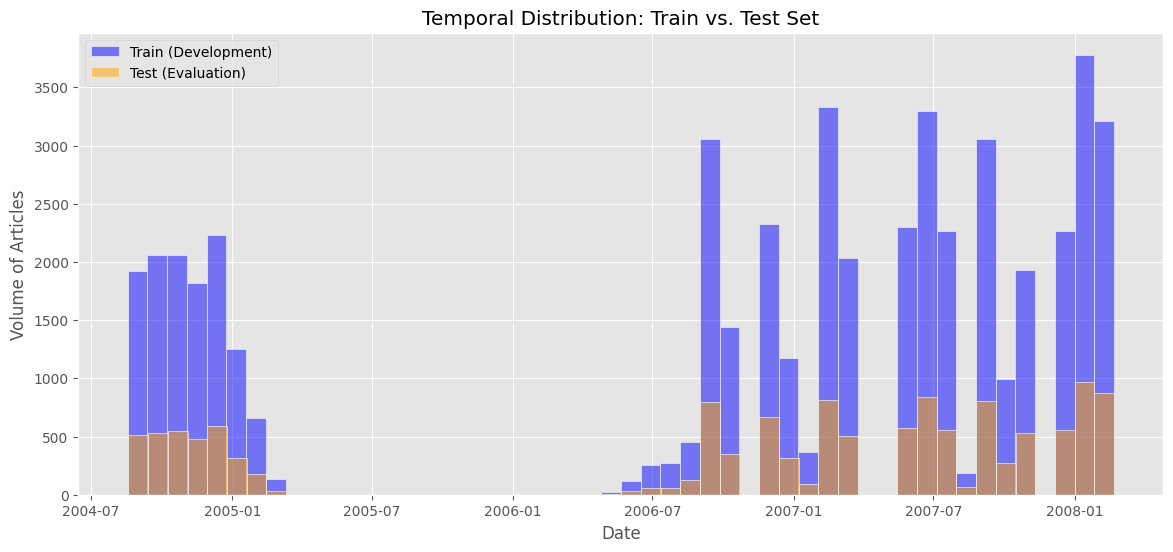

In [36]:
try:
    df_eval = pd.read_csv('./dataset/evaluation.csv')
    df_eval['timestamp'] = pd.to_datetime(df_eval['timestamp'], errors='coerce')
    has_eval = True
except FileNotFoundError:
    print("Evaluation set not found. Plotting Train only.")
    has_eval = False

plt.figure(figsize=(14, 6))

# Plot Train (Blue)
sns.histplot(df_clean['timestamp'], color='blue', label='Train (Development)', kde=False, bins=50, alpha=0.5)

# Plot Test (Orange) if available
if has_eval:
    sns.histplot(df_eval['timestamp'], color='orange', label='Test (Evaluation)', kde=False, bins=50, alpha=0.5)

plt.title('Temporal Distribution: Train vs. Test Set')
plt.xlabel('Date')
plt.ylabel('Volume of Articles')
plt.legend()
plt.show()

### d. Text Lengths

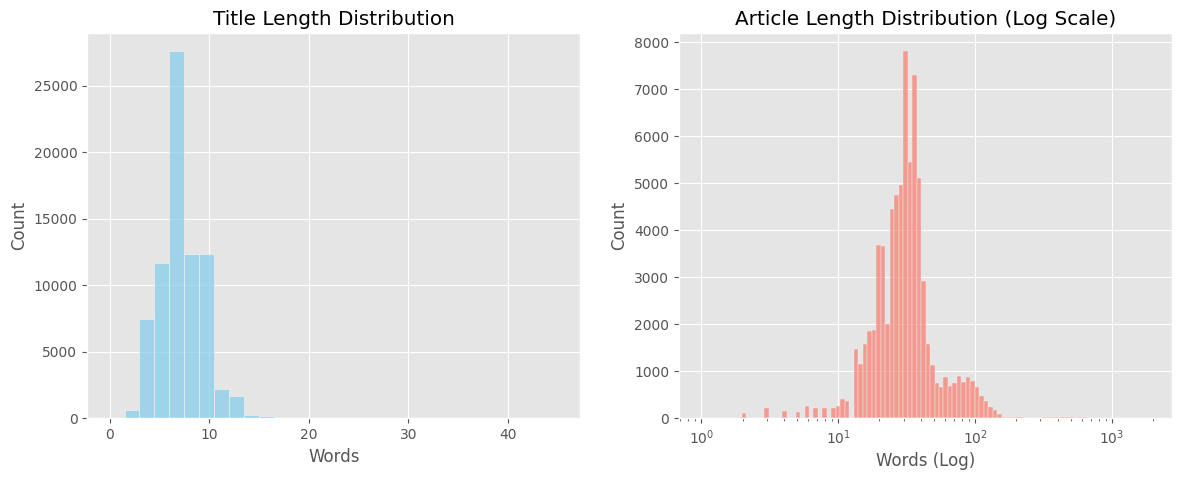

Article Length Stats:
 count    76613.0
mean        36.1
std         40.2
min          0.0
25%         22.0
50%         30.0
75%         38.0
max       1888.0
Name: article_len, dtype: float64


In [37]:
df_clean['title_len'] = df_clean['title'].str.split().str.len().fillna(0).astype(int)
df_clean['article_len'] = df_clean['article'].str.split().str.len().fillna(0).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Title Length
sns.histplot(df_clean['title_len'], bins=30, ax=axes[0], color='skyblue')
axes[0].set_title('Title Length Distribution')
axes[0].set_xlabel('Words')

# Article Length (Log Scale)
sns.histplot(df_clean['article_len'], bins=100, ax=axes[1], color='salmon', log_scale=True)
axes[1].set_title('Article Length Distribution (Log Scale)')
axes[1].set_xlabel('Words (Log)')

plt.show()

# Print stats for report
print("Article Length Stats:\n", df_clean['article_len'].describe().round(1))

## 1.4 Bi-Variate Analysis


### a. Source vs. Label

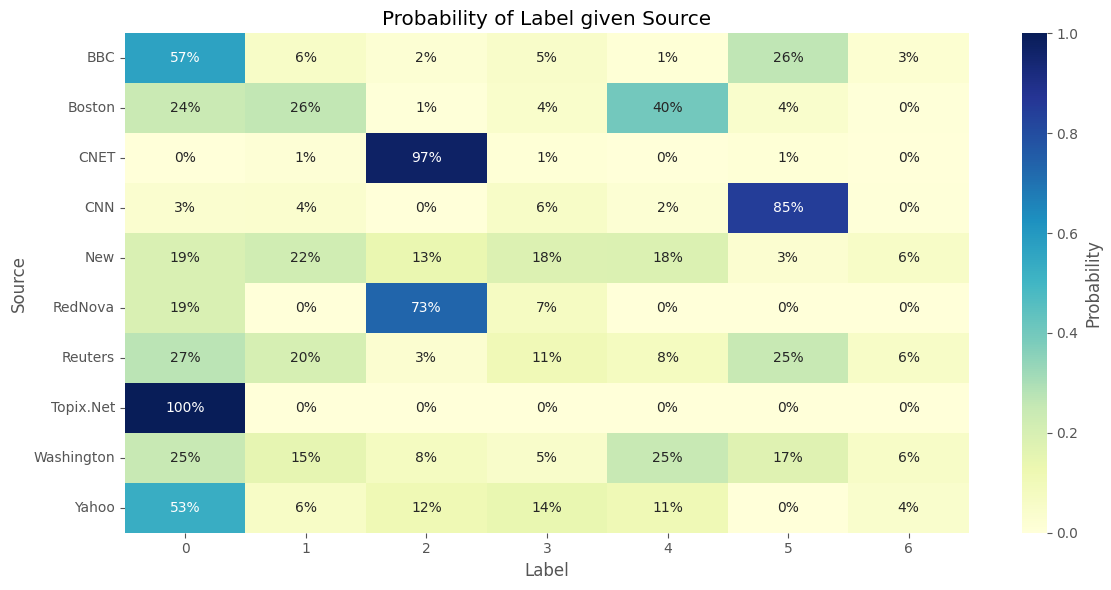

In [61]:
# We focus on the Top 10 sources to keep the heatmap readable
top_10_sources = df_clean['source'].value_counts().head(10).index
df_top_source = df_clean[df_clean['source'].isin(top_10_sources)]

# Create Cross-tabulation (normalized by row/source)
ct = pd.crosstab(df_top_source['source'], df_top_source['label'], normalize='index')

plt.figure(figsize=(12, 6))
sns.heatmap(ct, annot=True, fmt='.0%', cmap='YlGnBu', cbar_kws={'label': 'Probability'})
plt.title('Probability of Label given Source')
plt.ylabel('Source')
plt.xlabel('Label')
plt.tight_layout()
plt.show()

### b. Content Length vs. Label

/var/folders/kk/clxttl7j5wvbs_fcnydk843r0000gn/T/ipykernel_79832/1671616592.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


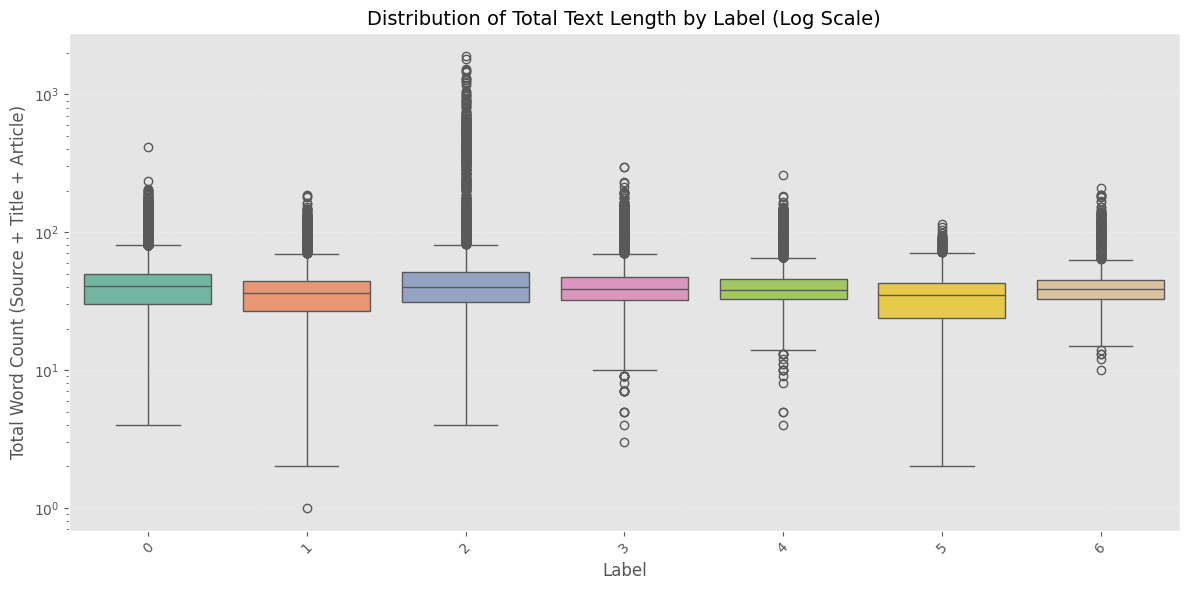

Median Word Counts by Label:
label
0    41.0
2    40.0
3    39.0
6    39.0
4    38.0
1    36.0
5    35.0
Name: total_len, dtype: float64


In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create Merged Text Feature (Source + Title + Article)
# We fill NaN with empty strings to avoid "Reuters nan nan" artifacts
df_clean['merged_text'] = (
    df_clean['source'].fillna('') + " " + 
    df_clean['title'].fillna('') + " " + 
    df_clean['article'].fillna('')
)
# Calculate Word Count for the merged text
df_clean['total_len'] = df_clean['merged_text'].str.split().str.len().fillna(0).astype(int)

# Visualization
plt.figure(figsize=(12, 6))

# Boxplot with log scale for y-axis
sorted_labels = sorted(df_clean['label'].unique())

sns.boxplot(
    data=df_clean, 
    x='label', 
    y='total_len', 
    order=sorted_labels, 
    palette='Set2'
)

plt.yscale('log') 

plt.title('Distribution of Total Text Length by Label (Log Scale)', fontsize=14)
plt.ylabel('Total Word Count (Source + Title + Article)')
plt.xlabel('Label')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Print Summary Statistics (for the report text)
print("Median Word Counts by Label:")
print(df_clean.groupby('label')['total_len'].median().sort_values(ascending=False))

In [40]:
df_clean['title'].tail(20)

78868             âTempoâ Chief Editor Remains Valiant
78869                            âThe Driveâ was start
78870            âThe Ringsâ Prompts a Long Legal Mire
78871        âThe war is already on&#39;: Rwandan leader
78872      âTreasureâ Still Jingling at the Box Office
78873        âUnusual riseâ only in cases of infection
78874                    âVanity Fairâ Bollywood style
78875            â72 Dolphins Salute Undefeated Patriots
78876                           âA Great Mobile Phoneâ
78877                       âApple Sets Wi-Fi on Fireâ
78878          âBattle for Supremacyâ or a circus act?
78879                              âBest Phone. Ever.â
78880                    âNothing less than fantasticâ
78881    âOne of the smallest, thinnest, and most exq...
78882          âPharmacyâ items to bring Â£11.1million
78883     âStress likely to affect foetus developmentâ
78884                          â¦And Then Thereâs Bon

In [41]:
df_clean['source'].tail(20)

78868              Laksamana
78869            Jaguars.com
78870                    New
78871                 Borneo
78872                    New
78873                    ABS
78874                  MSNBC
78875                 Boston
78876                  Apple
78877                  Apple
78878               Doghouse
78879                  Apple
78880                  Apple
78881                  Apple
78882    RealEstateGates.com
78883                 Indian
78884       All-Baseball.com
78885                 Forbes
78886             Washington
78887             Washington
Name: source, dtype: object

In [42]:
df_clean['article'].tail(20)

78868    Laksamana.Net - Despite being sentenced to one...
78869    com senior editor. It is the Jaguars&#39; vers...
78870    This week, heirs of J. R. R. Tolkien, author o...
78871    This file photo shows Rwandan President Paul K...
78872    The Disney film âNational Treasure: Book of ...
78873    While saying there is no outbreak of meningoco...
78874    William Makepeace Thackerayâs seminal 1848 n...
78875    Those Dolphins achieved the N.F.L.âs only pe...
78876    Calling its user interface âsimplicity itsel...
78877    Tom Yager writes for InfoWorld, âAt $179, Ap...
78878    What a night for a heavyweight showdown, what ...
78879    âTo call the iPhone the best phone Iâve ev...
78880    Thatâs what Cisco Cheng has to say about the...
78881    Awarding iPod nano an Excellent 8.0 rating, Do...
78882    More than 150 items from Damien Hirst popular ...
78883    Mumbai, December 20: By listening intently to ...
78884    Barry Bonds won his record seventh MVP award t.

The titles and articles are not truly clean. There are several issues to adress:

- Encoding Repair - As can be seen from above, there are titles and articles with problematic text encoding. Luckily, we do not have to treat them manually as a encoding fix library called 'ftfy' is compatible with our data.

- HTML Artifact Handling - There are HTML artifacts in the text. The 'beautifulsoup4' library has functions that can help us handle them.


- Source Tagging - We plan on concatenating source, title & article to a single text for tf-idf vectorization. Therefore, ensuring standardization for sources is necessary. Our other hypothesis is that models can benefit from having a single word in every document that starts with src_ and indicates the source, rather than feeding the source text as is.

In [43]:
df_clean['merged_text'] = (
    df_clean['source'].fillna('') + " " + 
    df_clean['title'].fillna('') + " " + 
    df_clean['article'].fillna('')
)

In [44]:
import ftfy

def repair_encoding(text):
    """
    Applies ftfy to fix text encoding issues (mojibake).
    Can be applied to a pandas Series via .apply().
    """
    if pd.isna(text):
        return ""
    return ftfy.fix_text(str(text))

In [45]:
df_clean['clean_text'] = df_clean['merged_text'].apply(repair_encoding)

In [46]:
df_clean['merged_text'].tail(10)

78878    Doghouse âBattle for Supremacyâ or a circu...
78879    Apple âBest Phone. Ever.â âTo call the i...
78880    Apple âNothing less than fantasticâ Thatâ...
78881    Apple âOne of the smallest, thinnest, and mo...
78882    RealEstateGates.com âPharmacyâ items to br...
78883    Indian âStress likely to affect foetus devel...
78884    All-Baseball.com â¦And Then Thereâs Bonds B...
78885                                             Forbes  
78886    Washington   House Committee on Energy and Com...
78887    Washington    <br clear="all"><a href="http://...
Name: merged_text, dtype: object

In [47]:
df_clean['clean_text'].tail(10)

78878    Doghouse "Battle for Supremacy" or a circus ac...
78879    Apple "Best Phone. Ever." "To call the iPhone ...
78880    Apple "Nothing less than fantastic" That's wha...
78881    Apple "One of the smallest, thinnest, and most...
78882    RealEstateGates.com "Pharmacy" items to bring ...
78883    Indian "Stress likely to affect foetus develop...
78884    All-Baseball.com …And Then There's Bonds Barry...
78885                                             Forbes  
78886    Washington   House Committee on Energy and Com...
78887    Washington    <br clear="all"><a href="http://...
Name: clean_text, dtype: object

In [49]:
def standardize_source_token(source_text):
    """
    Converts a source string into a standardized token format (e.g., 'BBC News' -> 'src_BBCNews').
    Removes spaces and special characters.
    """
    if pd.isna(source_text) or source_text == "":
        return "src_Unknown"
    
    # Remove special chars and spaces
    clean_source = re.sub(r'[^a-zA-Z0-9]', '', str(source_text))
    return f"src_{clean_source}"

In [50]:
df_clean['source_token'] = df_clean['source'].apply(standardize_source_token)

In [51]:
df_clean['source_token']

0               src_Syfycom
1            src_Washington
2            src_Washington
3            src_Washington
4            src_Washington
                ...        
78883            src_Indian
78884    src_AllBaseballcom
78885            src_Forbes
78886        src_Washington
78887        src_Washington
Name: source_token, Length: 76613, dtype: object

In [53]:
# Final text
df_clean['title_clean'] = df_clean['title'].apply(repair_encoding)
df_clean['article_clean'] = df_clean['article'].apply(repair_encoding)
df_clean['source_token'] = df_clean['source'].apply(standardize_source_token)

df_clean['final_text'] = df_clean['source_token'] + " " + df_clean['title_clean'] + " " + df_clean['article_clean']

In [54]:
df_clean[['title', 'title_clean', 'final_text']].head()


,title,title_clean,final_text
0,Sushmita sacks eight staff members,Sushmita sacks eight staff members,"src_Syfycom Sushmita sacks eight staff members ""Nobody knows the truth about what happened in the house..."
1,$3.4 Billion Investment Could Pull Delphi From Bankruptcy,$3.4 Billion Investment Could Pull Delphi From Bankruptcy,"src_Washington $3.4 Billion Investment Could Pull Delphi From Bankruptcy Auto parts supplier Delphi Corp. said today that a group of private capital companies has agreed to invest up to $3.4 billion to help the company pull out of bankruptcy, potentially helping avert a showdown with organized labor that could have further stressed the ailing U.S. auto industry.<br clear=""all""><a href=""http://ad.doubleclick.net/jump/wpni.rss/business;pos=ad9;tile=9;ad=rss;sz=479x40;ord=5118101252302"" target=""_blank""><img src=""http://ad.doubleclick.net/ad/wpni.rss/business;pos=ad9;tile=9;ad=rss;sz=479x40;ord=5118101252302"" border=""0"" vspace=""5""></a>"
2,$35 Billion Boost In Works for Kids' Health Care,$35 Billion Boost In Works for Kids' Health Care,src_Washington $35 Billion Boost In Works for Kids' Health Care Key lawmakers in the House and Senate negotiated into the night yesterday on a deal that would expand the State Children's Health Insurance Program by $35 billion over the next five years.
3,'04 Pentagon Report Cited Detention Concerns,'04 Pentagon Report Cited Detention Concerns,"src_Washington '04 Pentagon Report Cited Detention Concerns A previously undisclosed Pentagon report concluded that the three terrorism suspects held at a brig in South Carolina were subjected to months of isolation, and it warned that their ""unique"" solitary confinement could be viewed as violating U.S. detention standards.<br clear=""all""><a href=""http://ad.doubleclick.net/jump/wpni.rss/nation;pos=ad9;tile=9;ad=rss;sz=479x40;ord=50142317300"" target=""_blank""><img src=""http://ad.doubleclick.net/ad/wpni.rss/nation;pos=ad9;tile=9;ad=rss;sz=479x40;ord=50142317300"" border=""0"" vspace=""5""></a>"
4,'Clone-Free' Milk Could Get Label,'Clone-Free' Milk Could Get Label,"src_Washington 'Clone-Free' Milk Could Get Label Responding to consumer queasiness about eating meat and drinking milk from cloned animals, and frustrated by continued delays in the government approval process, the nation's two largest cloning companies will today roll out a voluntary program aimed at helping shoppers avoid food from clones."


In [55]:
# Option 1: Set pandas to show everything
pd.set_option('display.max_colwidth', None)
df_clean[['final_text']].tail(10)

# Option 2: Print specific rows loop (easiest to read)
for idx, text in df_clean['final_text'].tail(20).items():
    print(f"--- ID {idx} ---")
    print(text)
    print("\n")

--- ID 78868 ---
src_Laksamana 'Tempo' Chief Editor Remains Valiant Laksamana.Net - Despite being sentenced to one year in jail for defaming powerful tycoon Tomy Winata, Tempo magazine's chief editor Bambang Harymurti is confident of winning an appeal and has urged his peers in the media not to be afraid of imprisonment 


--- ID 78869 ---
src_Jaguarscom 'The Drive' was start com senior editor. It is the Jaguars' version of "The Drive," except the Tennessee Titans were doing the driving, 17 plays that chewed up 11 minutes and 14 seconds of the fourth 


--- ID 78870 ---
src_New 'The Rings' Prompts a Long Legal Mire This week, heirs of J. R. R. Tolkien, author of the "Lord of the Rings" trilogy and "The Hobbit," and a group of publishers filed a lawsuit demanding at least $150 million from New Line Cinema.


--- ID 78871 ---
src_Borneo 'The war is already on': Rwandan leader This file photo shows Rwandan President Paul Kagame listening to the opening remarks at the Presidential Guesthou